# TensorFlow Programming

**TF** offers different features, e.g.,
- ***Estimators API*** (less favorable alternative to `tf.keras`),
- data preprocessing and loading (e.g., `tf.data`, `tf.io`),
- image processing ops (`tf.image`),
- signal processing ops (`tf.signal`), etc.

**TensorFlow Lite** enables mobile device implementation:
 - ***TensorFlow.js*** for the JavaScript implementation in browsers,
 - ***TensorFlow Hub*** for downloading of pretrained NN, and
 - ***TensorFlow Extended (TFX)*** for machine learning production, e.g,
   - data validation,
   - preprocessing,
   - model analysis, and
   - serving (using ***TF Serving***).

Each TF operation (i.e., `op`), at the lowest level, is developed by using highly efficient C++ code that can be customized. Each op has its own implementation (i.e., **kernel**) for each device, e.g., ***TPUs*** (tensor processing units; especially designed ASIC chips for Deep Learning).

### Initialization

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
# assert tf.__version__ >= "2.4"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data structures
### Immutable tensors
- Tensors are similar to the `ndarray` data type but
  - it can be also scalar, and
  - it uses the 32-bit floats by default (as 64-bit is not typically neccessary).
- They can be created by `tf.constant()` and support indexing, and other operations.

In [2]:
# scalar tensor creation

tf.constant(42)

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [3]:
# matrix tensor creation

t = tf.constant([[1., 2., 3.], [4., 5., 6.]])

TensorShape([2, 3])

In [4]:
# ops similar to numpy ndarray

t.shape, t.dtype

(TensorShape([2, 3]), tf.float32)

In [5]:
# indexing

t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [7]:
# adding an extra dimension

t[..., 1, tf.newaxis]

# in Python "..." means "all dimensions behind the next"

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [8]:
# other ops

t + 10
tf.square(t)
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

- For portability you may use `keras.backend` instead, but it is not as complete as TF.

In [9]:
from tensorflow import keras

K = keras.backend
K.square(K.transpose(t)) + 10

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[11., 26.],
       [14., 35.],
       [19., 46.]], dtype=float32)>

- TF does not handle type conversion automarically (for performance), which can be enforced by `tf.cast()`.

In [10]:
try:
    tf.constant(2.0) + tf.constant(40)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

cannot compute AddV2 as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:AddV2]


In [13]:
t = tf.constant(40., dtype=tf.float64)

tf.constant(2.0) + tf.cast(t, tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

- Comparing to np, some functions may have different names mostly, e.g., `tf.reduce_mean()`, `tf.reduce_sum()`, `tf.reduce_max()`, as they use a reduce for the GPU kernel that can affect the results by changing the order, due to the limitation of 32-bit floats. Always pay attention to the dtypes.
- Use `.numpy()` to convert it into numpy

In [20]:
t = tf.constant(np.array([2., 4., 5.]))

t.numpy()

array([2., 4., 5.])

#### Strings
- `tf.string` (byte string tensors) are manageable by the `tf.strings` package.
- In python 3 each str is unicode (not byte); which might be enforced with "b" (but not always;  e.g., with é).

In [33]:
tf.constant(b"hello world")

<tf.Tensor: shape=(), dtype=string, numpy=b'hello world'>

- TF in python 3 can automatically converte each str to UTF-8, which are atomic, i.e., its length can be appeared if converted to Unicode tensors.


In [34]:
tf.constant("café")

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [30]:
# For clarification

u = tf.constant([ord(c) for c in "café"]) # ord() returns the Unicode characters.

u

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

In [21]:
b = tf.strings.unicode_encode(u, "UTF-8")
b

<tf.Tensor: shape=(), dtype=string, numpy=b'caf\xc3\xa9'>

In [22]:
tf.strings.length(b, unit="UTF8_CHAR")

<tf.Tensor: shape=(), dtype=int32, numpy=4>

In [23]:
tf.strings.unicode_decode(b, "UTF-8")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 99,  97, 102, 233])>

#### String arrays

In [36]:
p = tf.constant(["Café", "Coffee", "caffè", "咖啡"])

tf.strings.length(p, unit="UTF8_CHAR")

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([4, 6, 5, 2])>

In [37]:
r = tf.strings.unicode_decode(p, "UTF8")
r

<tf.RaggedTensor [[67, 97, 102, 233], [67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232], [21654, 21857]]>

#### Ragged tensors

- A `tf.RaggedTensor` is a tensor, managed by the `tf.ragged` package, with at least one *ragged dimension* (i.e., a dimension with slices of different lengths.)

In [39]:
print(r[1])
print(r[1:3])

tf.Tensor([ 67 111 102 102 101 101], shape=(6,), dtype=int32)
<tf.RaggedTensor [[67, 111, 102, 102, 101, 101], [99, 97, 102, 102, 232]]>


In [40]:
r3 = tf.ragged.constant([[68, 69, 70], [71], [], [72, 73]])
print(tf.concat([r, r3], axis=1))

<tf.RaggedTensor [[67, 97, 102, 233, 68, 69, 70], [67, 111, 102, 102, 101, 101, 71], [99, 97, 102, 102, 232], [21654, 21857, 72, 73]]>


In [28]:
tf.strings.unicode_encode(r3, "UTF-8")

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'DEF', b'G', b'', b'HI'], dtype=object)>

In [29]:
r.to_tensor()

<tf.Tensor: shape=(4, 6), dtype=int32, numpy=
array([[   67,    97,   102,   233,     0,     0],
       [   67,   111,   102,   102,   101,   101],
       [   99,    97,   102,   102,   232,     0],
       [21654, 21857,     0,     0,     0,     0]])>

#### Sparse tensors

- `tf.SparseTensor` is a mostly zero-valued tensor.

In [43]:
s = tf.SparseTensor(indices=[[0, 1], [1, 0], [2, 3]],
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])
print(s)

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [44]:
tf.sparse.to_dense(s)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [2., 0., 0., 0.],
       [0., 0., 0., 3.]], dtype=float32)>

In [32]:
s2 = s * 2.0

In [33]:
try:
    s3 = s + 1.
except TypeError as ex:
    print(ex)

unsupported operand type(s) for +: 'SparseTensor' and 'float'


In [34]:
s4 = tf.constant([[10., 20.], [30., 40.], [50., 60.], [70., 80.]])
tf.sparse.sparse_dense_matmul(s, s4)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 30.,  40.],
       [ 20.,  40.],
       [210., 240.]], dtype=float32)>

In [35]:
s5 = tf.SparseTensor(indices=[[0, 2], [0, 1]],
                     values=[1., 2.],
                     dense_shape=[3, 4])
print(s5)

SparseTensor(indices=tf.Tensor(
[[0 2]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([1. 2.], shape=(2,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))


In [36]:
try:
    tf.sparse.to_dense(s5)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

indices[1] = [0,1] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SparseToDense]


In [37]:
s6 = tf.sparse.reorder(s5)
tf.sparse.to_dense(s6)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[0., 2., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

#### Sets
- `tf.sets` is a package to work with sets.

In [38]:
set1 = tf.constant([[2, 3, 5, 7], [7, 9, 0, 0]])
set2 = tf.constant([[4, 5, 6], [9, 10, 0]])
tf.sparse.to_dense(tf.sets.union(set1, set2))

<tf.Tensor: shape=(2, 6), dtype=int32, numpy=
array([[ 2,  3,  4,  5,  6,  7],
       [ 0,  7,  9, 10,  0,  0]])>

In [39]:
tf.sets.difference(set1, set2)

In [40]:
tf.sparse.to_dense(tf.sets.intersection(set1, set2))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[5, 0],
       [0, 9]])>

#### Variables

- `tf.Variable` is similar to `tf.Tensor` but can also update its value by `assign()`, or relatively by `assign_add()` or `assign_sub()`.
- Individual cells and slices can also be changed by assigning to them directly or by `scatter_nd_update()`.
- In practice, with Keras we hardly need them.

In [76]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]])

In [77]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [78]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [79]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [80]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]],
                    updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

- For indexing, we may also use `.scatter_update` based on the `tf.IndexedSlices` to define the new values and their indices (by a sparse representaion that imporves perfomance for big data). 

In [81]:
sparse_delta = tf.IndexedSlices(values=[[1., 2., 3.]],
                                indices=[0])
v.scatter_update(sparse_delta)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[  1.,   2.,   3.],
       [  8.,  10., 200.]], dtype=float32)>

#### Tensor Arrays

They are per-time-step and write-once tensor arrays.

In [47]:
array = tf.TensorArray(dtype=tf.float32, size=3)
array = array.write(0, tf.constant([1., 2.]))
array = array.write(1, tf.constant([3., 10.]))
array = array.write(2, tf.constant([5., 7.]))

In [48]:
array.read(1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 3., 10.], dtype=float32)>

In [49]:
array.stack()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 2.],
       [0., 0.],
       [5., 7.]], dtype=float32)>

In [50]:
mean, variance = tf.nn.moments(array.stack(), axes=0)
mean, variance

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 3.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.6666665, 8.666667 ], dtype=float32)>)

#### Queues
**Queuing** is the TF method of threading, to handle different tasks asynchronously. `tf.queue` is a package dealing with storing tensors in multiple steps mostly for high performance customized parallel code, e.g. using,
- First In, First Out (FIFO) queues (`FIFOQueue`), 
- queues that can prioritize some (`PriorityQueue`),
- or shuffle them (`RandomShuffleQueue`),
- and batch items with different shapes using padding (`PaddingFIFOQueue`).

## TF Functions and Graphs

### TF Functions

- `tf.function()` or `@tf.function` will make an optimized computation graph (from python functions). However, when using Keras models the graph is generated automatically (and we do not need these methods). To prohibit Keras from this:
  - use `dynamic=True` in the custom layers and methods, or
  - alternatively use `run_eagerly=True` when compiling.
- Use TF functions instead of other functions if possible as calling `tf.py_function()` for many times, may hinder the performance and portability.

In [1]:
def cube(x):
    return x ** 3

cube(2) # the output is not TF tensor

8

In [4]:
cube(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [5]:
tf_cube = tf.function(cube)
tf_cube

In [6]:
# alternatively

@tf.function
def tf_cube(x):
    return x ** 3

In [7]:
tf_cube(2) # note the output is of int32

<tf.Tensor: shape=(), dtype=int32, numpy=8>

In [8]:
tf_cube.python_function(2)

8

### AutoGraph and Tracing

- TF first in the **AutoGraph** process analyzes the Python function’s source code to capture control flow statements, e.g., for loops. Then, an upgraded TF version of the code is generated (see, e.g., figure below).
- During **tracing**, TF calls this function, passes a symbolic tensor to it, and make a node for it without computation (i.e., running in **graph mode** in contrary to the regular or **eager mode**).
 
![alt text for screen readers](\img\graphtracing.jpg)
Figure 1. Example of AutoGraph and Tracing.

- Once a function is traced, TF creates a new ***concrete function***, can be accessed by `.get_concrete_function()`, which can also be used to explore its graph using `.graph.get_operations()`

In [212]:
concrete_function = tf_cube.get_concrete_function(tf.constant(2.0))

In [213]:
concrete_function(tf.constant(2.0))

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [214]:
concrete_function.graph

In [215]:
ops = concrete_function.graph.get_operations()
ops

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'pow/y' type=Const>,
 <tf.Operation 'pow' type=Pow>,
 <tf.Operation 'Identity' type=Identity>]

In [222]:
pow_op = ops[2]
list(pow_op.inputs)

[<tf.Tensor 'x:0' shape=() dtype=float32>,
 <tf.Tensor 'pow/y:0' shape=() dtype=float32>]

In [220]:
pow_op.outputs

[<tf.Tensor 'pow:0' shape=() dtype=float32>]

In [223]:
concrete_function.graph.get_operation_by_name('x')

<tf.Operation 'x' type=Placeholder>

In [217]:
concrete_function.graph.get_tensor_by_name('Identity:0')

<tf.Tensor 'Identity:0' shape=() dtype=float32>

In [218]:
concrete_function.function_def.signature

name: "__inference_cube_1908399"
input_arg {
  name: "x"
  type: DT_FLOAT
}
output_arg {
  name: "identity"
  type: DT_FLOAT
}

- TF Functions can handle ***polymorphism*** (i.e., varying argument types and shapes) only by updating the graphs (happening only if the tensor size or shape, or python values are chagned). Therefore,
  - delete redundant TF Functions to release RAM space, and
  - use python values only for unique values, e.g., hyperparameters.

In [225]:
@tf.function
def tf_cube(x):
    print("print:", x)
    return x ** 3

In [226]:
result = tf_cube(tf.constant(2.0))

print: Tensor("x:0", shape=(), dtype=float32)


In [227]:
result

<tf.Tensor: shape=(), dtype=float32, numpy=8.0>

In [228]:
result = tf_cube(2)
result = tf_cube(3)
result = tf_cube(tf.constant([[1., 2.]])) # New shape: trace!
result = tf_cube(tf.constant([[3., 4.], [5., 6.]])) # New shape: trace!
result = tf_cube(tf.constant([[7., 8.], [9., 10.], [11., 12.]])) # New shape: trace!

print: 2
print: 3
print: Tensor("x:0", shape=(1, 2), dtype=float32)
print: Tensor("x:0", shape=(2, 2), dtype=float32)
print: Tensor("x:0", shape=(3, 2), dtype=float32)


- We may also define `input_signature` for the TF function.

In [229]:
@tf.function(input_signature=[tf.TensorSpec([None, 28, 28], tf.float32)])
def shrink(images):
    print("Tracing", images)
    return images[:, ::2, ::2] # drop half the rows and columns

In [230]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [231]:
img_batch_1 = tf.random.uniform(shape=[100, 28, 28])
img_batch_2 = tf.random.uniform(shape=[50, 28, 28])
preprocessed_images = shrink(img_batch_1) # Traces the function.
preprocessed_images = shrink(img_batch_2) # Reuses the same concrete function.

Tracing Tensor("images:0", shape=(None, 28, 28), dtype=float32)


In [232]:
img_batch_3 = tf.random.uniform(shape=[2, 2, 2])
try:
    preprocessed_images = shrink(img_batch_3)  # rejects unexpected types or shapes
except ValueError as ex:
    print(ex)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[[0.7413678  0.62854624]
  [0.01738465 0.3431449 ]]

 [[0.51063764 0.3777541 ]
  [0.07321596 0.02137029]]], shape=(2, 2, 2), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name=None))


- If in a loop `range()` is used instead of `tf.range()`, the loop cannot capture the graph (not a *dymaic* for loop) and runs only during tracing. It is not generally fine unless you prefer to make a new graph for each loop (e.g., when making a new layer in a network).

In [235]:
# A "static" for loop using range():

@tf.function
def add_10(x):
    for i in range(10):
        x += 1
    return x

add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'add/y' type=Const>,
 <tf.Operation 'add' type=AddV2>,
 <tf.Operation 'add_1/y' type=Const>,
 <tf.Operation 'add_1' type=AddV2>,
 <tf.Operation 'add_2/y' type=Const>,
 <tf.Operation 'add_2' type=AddV2>,
 <tf.Operation 'add_3/y' type=Const>,
 <tf.Operation 'add_3' type=AddV2>,
 <tf.Operation 'add_4/y' type=Const>,
 <tf.Operation 'add_4' type=AddV2>,
 <tf.Operation 'add_5/y' type=Const>,
 <tf.Operation 'add_5' type=AddV2>,
 <tf.Operation 'add_6/y' type=Const>,
 <tf.Operation 'add_6' type=AddV2>,
 <tf.Operation 'add_7/y' type=Const>,
 <tf.Operation 'add_7' type=AddV2>,
 <tf.Operation 'add_8/y' type=Const>,
 <tf.Operation 'add_8' type=AddV2>,
 <tf.Operation 'add_9/y' type=Const>,
 <tf.Operation 'add_9' type=AddV2>,
 <tf.Operation 'Identity' type=Identity>]

In [236]:
# A "dynamic" loop using tf.while_loop():

@tf.function
def add_10(x):
    condition = lambda i, x: tf.less(i, 10)
    body = lambda i, x: (tf.add(i, 1), tf.add(x, 1))
    final_i, final_x = tf.while_loop(condition, body, [tf.constant(0), x])
    return final_x

add_10.get_concrete_function(tf.constant(5)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

In [238]:
# A "dynamic" for loop using tf.range() (captured by autograph):

@tf.function
def add_10(x):
    for i in tf.range(10):
        x = x + 1
    return x

add_10.get_concrete_function(tf.constant(0)).graph.get_operations()

[<tf.Operation 'x' type=Placeholder>,
 <tf.Operation 'range/start' type=Const>,
 <tf.Operation 'range/limit' type=Const>,
 <tf.Operation 'range/delta' type=Const>,
 <tf.Operation 'range' type=Range>,
 <tf.Operation 'while/maximum_iterations' type=Const>,
 <tf.Operation 'while/loop_counter' type=Const>,
 <tf.Operation 'while' type=StatelessWhile>,
 <tf.Operation 'Identity' type=Identity>]

- Calling functions from other libraries is not part of a graph, and therefore, it happens only for tracing. Some implications are:
  - If your non-TF code has a side effects (e.g., updating a python counter), they only occurs during tracing (and not for the other TF function calls).
  - E.g., if for `np.random.rand()` and `tf.random.rand()`, we pass constants of the same shape and types but different values, the NumPy random numbers are the same while the TF ones are different.

In [248]:
# E.g.,

counter = tf.Variable(0)

@tf.function
def increment(counter, c=1):
    return counter.assign_add(c)

increment(counter)
increment(counter)

function_def = increment.get_concrete_function(counter).function_def
function_def.signature.input_arg[0]

name: "counter"
type: DT_RESOURCE

In [246]:
counter = tf.Variable(0)

@tf.function
def increment(c=1):
    return counter.assign_add(c)

increment()
increment()

function_def = increment.get_concrete_function().function_def
function_def.signature.input_arg[0]

name: "assignaddvariableop_resource"
type: DT_RESOURCE

In [249]:
class Counter:
    def __init__(self):
        self.counter = tf.Variable(0)

    @tf.function
    def increment(self, c=1):
        return self.counter.assign_add(c)

c = Counter()
c.increment()
c.increment()

<tf.Tensor: shape=(), dtype=int32, numpy=2>

- You may show the TF code by `tf.autograph.to_code()`

In [250]:
@tf.function
def add_10(x):
    for i in tf.range(10):
        x += 1
    return x

print(tf.autograph.to_code(add_10.python_function))

def tf__add_10(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def loop_body(iterates, x):
      i = iterates
      x += 1
      return x,
    x, = ag__.for_stmt(ag__.converted_call(tf.range, (10,), None, fscope), None, loop_body, get_state, set_state, (x,), ('x',), ())
    do_return = True
    retval_ = fscope.mark_return_value(x)
  do_return,
  return ag__.retval(retval_)



In [253]:
# alternatively

def display_tf_code(func):
    from IPython.display import display, Markdown
    if hasattr(func, "python_function"):
        func = func.python_function
    code = tf.autograph.to_code(func)
    display(Markdown('```python\n{}\n```'.format(code)))

display_tf_code(add_10)

```python
def tf__add_10(x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('add_10', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def loop_body(iterates, x):
      i = iterates
      x += 1
      return x,
    x, = ag__.for_stmt(ag__.converted_call(tf.range, (10,), None, fscope), None, loop_body, get_state, set_state, (x,), ('x',), ())
    do_return = True
    retval_ = fscope.mark_return_value(x)
  do_return,
  return ag__.retval(retval_)

```

Other points:
- Python source code should be accessible (e.g., in python shell or the compiled *.pyc files do not have such access).
- Use the vectorized version when possible.
- In a function, TF variables and stateful objects (e.g., TF datasets or queues) should be created upon the very first call. Generally, it is more preferred to make them outside functions (e.g., in the `build()` method of a custom layer).

### Using TF Functions with tf.keras (or Not)

By default, tf.keras does not need tf.function():

In [254]:
# Custom loss function
def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))

In [255]:
# Custom metric function
def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [256]:
# Custom layer
class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        self.biases = self.add_weight(name='bias', 
                                      shape=(self.units,),
                                      initializer='zeros',
                                      trainable=True)
        super().build(input_shape)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [258]:
# Custom model

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

class MyModel(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing metric my_mae()
Tracing loss my_mse()
Train on 11610 samples, validate on 3870 samples
Epoch 1/2
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
10496/11610 [==========================>...] - ETA: 0s - loss: 1.3640 - my_mae: 0.8114Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
11610/11610 [==============================] - 1s 94us/sample - loss: 1.2838 - my_mae: 0.7826 - val_loss: 0.4503 - val_my_mae: 0.4879
Epoch 2/2
5160/5160 [==============================] - 0s 22us/sample - loss: 0.4174 - my_mae: 0.4584


[0.4173873734566592, 0.45841503]

In [260]:
# You can turn this off by creating the model with dynamic=True
# (or calling super().__init__(dynamic=True, **kwargs) in the model's constructor):

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = MyModel(dynamic=True)
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

# alternatively use run_eagerly=True
# model = MyModel()
# model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae], run_eagerly=True)

model.fit(X_train_scaled[:64], y_train[:64], epochs=1,
          validation_data=(X_valid_scaled[:64], y_valid[:64]), verbose=0)
model.evaluate(X_test_scaled[:64], y_test[:64], verbose=0)

# Note the custom code will be called at each iteration.
# Let's use a tiny datasets to avoid getting too much output:

Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()
Tracing MyModel.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing MyDense.call()
Tracing loss my_mse()
Tracing metric my_mae()


[5.50464653968811, 2.056248]

## Computing Gradients with Autodiff
- `tf.GradientTape()` and its `gradient()` method can efficiently find the derivatives (comparing to the numerical methods) with respect to variables.

In [9]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

In [12]:
# manually approximation of gradients

w1, w2 = 5, 3
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps

36.000003007075065

In [13]:
# using autodiff

w1, w2 = tf.Variable(5.), tf.Variable(3.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

gradients = tape.gradient(z, [w1, w2])

gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- For vectors, TF finds the gradient of the vector sum (e.g., referring to the sum of the losses). To find specific component (i.e., partial derivate), we may use `persistent=True` finding one set of gradients (i.e., ***Jacobeans***).

In [151]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)

try:
    dz_dw2 = tape.gradient(z, w2)
except RuntimeError as ex:
    print(ex)

GradientTape.gradient can only be called once on non-persistent tapes.


In [152]:
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)
dz_dw2 = tape.gradient(z, w2) # works now!

del tape # delete it to make the tape persistent.

In [155]:
# Another e.g.,

with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=136.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [16]:
# alternatively

with tf.GradientTape(persistent=True) as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tf.reduce_sum(tf.stack([tape.gradient(z, [w1, w2]) for z in (z1, z2, z3)]), axis=0)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([136.,  30.], dtype=float32)>

In [6]:
del tape

In [159]:
# 2nd order derivate e.g.,

with tf.GradientTape(persistent=True) as hessian_tape: # hessian is the second order derivative of a vector
    with tf.GradientTape() as jacobian_tape:
        z = f(w1, w2)
    jacobians = jacobian_tape.gradient(z, [w1, w2])
hessians = [hessian_tape.gradient(jacobian, [w1, w2])
            for jacobian in jacobians]
del hessian_tape

In [160]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [161]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=6.0>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.0>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0>, None]]

- `tf.stop_gradient()` can exclude some parts from backprop.

In [162]:
def f(w1, w2):
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)

with tf.GradientTape() as tape:
    z = f(w1, w2)

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

- We can force the constants to be derivable by `watch()`.

In [ ]:
c1, c2 = tf.constant(5.), tf.constant(3.)

with tf.GradientTape() as tape:
    tape.watch(c1) # tf.constant does not have gradients unless we force them by tape.watch()
    tape.watch(c2) # .watch is useful when
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=36.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

- With numerical issues (e.g., zero division) find the *analytical derivative* while decorating with `@tf.custom_gradient` and returning the increment.

In [165]:
# e.g., zero devision:

x = tf.Variable([100.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([nan], dtype=float32)>]

In [181]:
@tf.custom_gradient
def my_better_softplus(z):
    exp = tf.exp(z)
    def my_softplus_gradients(grad):
        return grad / (1 + 1 / exp)
    return tf.math.log(exp + 1), my_softplus_gradients

In [182]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_better_softplus(x)

z, tape.gradient(z, [x])

# to avoid [inf] softplus output, you may define it by tf.where(z > 30., z, tf.math.log(tf.exp(z) + 1.))

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([inf], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

## Customization
Some of the follwing customizations may not be portable for some Keras versions.

### Custom loss function
E.g., if the data was too noisy, MSE and MAE may penalize respectively too much or too few, then `keras.losses.Huber()` may be used. We can also make our own, for this:
- make the code vectorized, if possible;
- use only TF objects;
- try to return a tensor having one loss per instance (instead of the mean) so that keras can add sample (or class) weights later.

In [51]:
# preprocessing

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [52]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

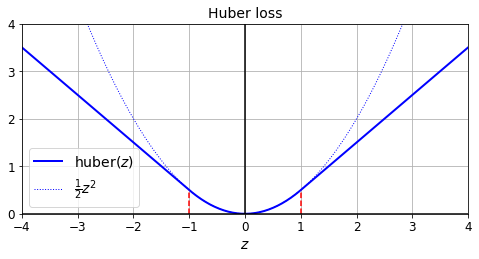

In [53]:
# illustrating huber loss

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [54]:
# e.g., of a model

input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [55]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [56]:
# fit with this loss

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 79us/sample - loss: 0.6247 - mae: 0.9969 - val_loss: 0.2884 - val_mae: 0.5913
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2193 - mae: 0.5176 - val_loss: 0.2361 - val_mae: 0.5232


### Saving and loading custom objects:

- To load the saved functions, the names should also be mapped to each custom function.

In [57]:
# save

model.save("my_model_with_a_custom_loss.h5")

In [58]:
# load

model = keras.models.load_model("my_model_with_a_custom_loss.h5",
                                custom_objects={"huber_fn": huber_fn})

In [59]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 59us/sample - loss: 0.2056 - mae: 0.4982 - val_loss: 0.2170 - val_mae: 0.5037
Epoch 2/2
11610/11610 [==============================] - 0s 42us/sample - loss: 0.2006 - mae: 0.4911 - val_loss: 0.2097 - val_mae: 0.4908


- Also, the input parameters to theses functions can be saved if a function constructor is used.

In [60]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = threshold * tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [61]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=["mae"])

In [62]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 72us/sample - loss: 0.2229 - mae: 0.4893 - val_loss: 0.2525 - val_mae: 0.4973
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2189 - mae: 0.4856 - val_loss: 0.2338 - val_mae: 0.4765


In [63]:
model.save("my_model_with_a_custom_loss_threshold_2.h5")

In [64]:
model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
                                custom_objects={"huber_fn": create_huber(2.0)})

In [65]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 58us/sample - loss: 0.2148 - mae: 0.4796 - val_loss: 0.2111 - val_mae: 0.4713
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.2123 - mae: 0.4775 - val_loss: 0.1970 - val_mae: 0.4534


- Alternatively, to save the inputs to the custom function, a class may be employed in which
  - the `get_config()` method returns a dictionary to map hyperparameters (new and base ones),
  - `call()` computes the loss, and
  - the constructor uses the ***reduction algorithms***, e.g., (by default) via `sum_over_batch_size` (i.e., the weighted summed loss divided by the batch size).
- In this case, loading only requires mapping of the class name.


In [66]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [67]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [68]:
model.compile(loss=HuberLoss(2.), optimizer="nadam", metrics=["mae"])

In [69]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 81us/sample - loss: 0.6934 - mae: 0.8818 - val_loss: 0.3288 - val_mae: 0.5451
Epoch 2/2
11610/11610 [==============================] - 0s 39us/sample - loss: 0.2402 - mae: 0.5077 - val_loss: 0.2315 - val_mae: 0.4861


In [70]:
model.loss.threshold

2.0

In [71]:
model.save("my_model_with_a_custom_loss_class_.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
                                custom_objects={"HuberLoss": HuberLoss})

### Other simple custom functions

In [72]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

In [74]:
layer = keras.layers.Dense(1, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

In [75]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [76]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [77]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [78]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 74us/sample - loss: 1.4486 - mae: 0.8727 - val_loss: 2.4208 - val_mae: 0.5681
Epoch 2/2
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5848 - mae: 0.5260 - val_loss: 1.6040 - val_mae: 0.5122


In [79]:
model.save("my_model_with_many_custom_parts.h5")

In [80]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "my_l1_regularizer": my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

In [83]:
# Or alternatively

class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, factor):
        self.factor = factor
    def __call__(self, weights):  
        return tf.reduce_sum(tf.abs(self.factor * weights))
    def get_config(self):
        return {"factor": self.factor}

Considering the above subclass, note that:
- this time we do use `.get_config()`, contrary to the loss custom subclass.
- use `call()` for losses, layers (including activation functions), and models, while use `__call__()` for regularizers, initializers, and constraints.

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=MyL1Regularizer(0.01),
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

In [86]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 72us/sample - loss: 1.4486 - mae: 0.8727 - val_loss: 2.4208 - val_mae: 0.5681
Epoch 2/2
11610/11610 [==============================] - 0s 39us/sample - loss: 0.5848 - mae: 0.5260 - val_loss: 1.6040 - val_mae: 0.5122


In [87]:
model.save("my_model_with_many_custom_parts.h5")

In [88]:
model = keras.models.load_model(
    "my_model_with_many_custom_parts.h5",
    custom_objects={
       "MyL1Regularizer": MyL1Regularizer,
       "my_positive_weights": my_positive_weights,
       "my_glorot_initializer": my_glorot_initializer,
       "my_softplus": my_softplus,
    })

### Custom Metrics
- Generally, metrics are used for evaluation, which are in comparison to the loss functions, they must be easily interpretable while can be non-differentiable with possible 0 gradients.
- Their implementation may be sometimes similar to the custom loss.


In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [91]:
model.compile(loss="mse", optimizer="nadam", metrics=[create_huber(2.0)])

In [92]:
model.fit(X_train_scaled, y_train, epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 58us/sample - loss: 2.0326 - huber_fn: 0.9038
Epoch 2/2
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5862 - huber_fn: 0.2682


- Note that loss = metric * mean of sample weights (plus some floating point precision error).

In [93]:
model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[create_huber(2.0)])

In [94]:
sample_weight = np.random.rand(len(y_train))
history = model.fit(X_train_scaled, y_train, epochs=2, sample_weight=sample_weight)

  ...
    to  
  ['...']
Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 72us/sample - loss: 0.1174 - huber_fn: 0.2375
Epoch 2/2
11610/11610 [==============================] - 0s 34us/sample - loss: 0.1137 - huber_fn: 0.2306


In [95]:
history.history["loss"][0], history.history["huber_fn"][0] * sample_weight.mean()

(0.11744698936265671, 0.11787283955197686)

- But sometimes loss and metrics have different implementations. E.g., `keras.metrics.Precision()` updates the model gradually, batch after batch, i.e., a ***streaming or stateful*** metric, but it also considers the whole items (not just the means of each batch).

In [96]:
# e.g., of such metrics
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1])  # labels and predictions (weights can be added)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8>

In [97]:
# 2nd batch

precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])
precision.result() # current value

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [98]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]

In [99]:
precision.reset_states()

- To create a ***streaming metric***, use subclassing in which
  - `add_weight()` initializes the variables that are updated over multiple batches,
  - `update_state()` is called when an instance of the class is called,
  - `result()` returns then the computed value,
  - `get_config()` deals with saving the hyperparameters, and
  - `reset_states()`, with the default value 0.0, can also be configured.

In [100]:
class HuberMetric(keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred) # returns for each sample
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
    def result(self):
        return self.total / self.count
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [101]:
m = HuberMetric(2.)

m(tf.constant([[2.]]), tf.constant([[10.]]))

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=14.0>

In [102]:
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7

m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=7.0>

In [103]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=21.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [104]:
m.reset_states()

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=create_huber(2.0), optimizer="nadam", metrics=[HuberMetric(2.0)])

model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32), epochs=2)

Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 61us/sample - loss: 0.8646 - huber_metric: 0.8646
Epoch 2/2
11610/11610 [==============================] - 0s 32us/sample - loss: 0.2564 - huber_metric: 0.2564


In [105]:
model.metrics[-1].threshold

2.0

In [106]:
model.save("my_model_with_a_custom_metric.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric.h5",
                                custom_objects={"huber_fn": create_huber(2.0),
                                                "HuberMetric": HuberMetric})

In [108]:
# A simpler alternative for this case:
# It handles shapes better and supports sample weights.

class HuberMetric(keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        # it refers to one class above to compute the weighted mean.
        super(HuberMetric, self).update_state(metric, sample_weight)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [109]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

model.compile(loss=keras.losses.Huber(2.0), optimizer="nadam", weighted_metrics=[HuberMetric(2.0)])


sample_weight = np.random.rand(len(y_train))

history = model.fit(X_train_scaled.astype(np.float32), y_train.astype(np.float32),
                    epochs=2, sample_weight=sample_weight)

  ...
    to  
  ['...']
Train on 11610 samples
Epoch 1/2
11610/11610 [==============================] - 1s 83us/sample - loss: 0.4330 - HuberMetric: 0.8725
Epoch 2/2
11610/11610 [==============================] - 0s 33us/sample - loss: 0.1286 - HuberMetric: 0.2592


In [110]:
history.history["loss"][0], history.history["HuberMetric"][0] * sample_weight.mean()

(0.4329961389008008, 0.4329960495905965)

In [111]:
model.save("my_model_with_a_custom_metric_v2.h5")

In [ ]:
model = keras.models.load_model("my_model_with_a_custom_metric_v2.h5",
                                custom_objects={"HuberMetric": HuberMetric})

### Custom Layers

- To make an exotic layer, or simply a block of layers, we may create a custom layer.
- Custom layers with no weights (like `keras.layers.Flatten` or `keras.layers.ReLU`) can be created by `keras.layers.Lambda`:

In [113]:
# exponential layers may better handle values that are positive and have very different scales.

exponential_layer = keras.layers.Lambda(lambda x: tf.exp(x))

In [114]:
# equivalent to activation=tf.exp, activation=keras.activations.exponential, or simply activation="exponential".

exponential_layer([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.36787945, 1.        , 2.7182817 ], dtype=float32)>

In [115]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [116]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=input_shape),
    keras.layers.Dense(1),
    exponential_layer
])
model.compile(loss="mse", optimizer="sgd")
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 49us/sample - loss: 3.6109 - val_loss: 1.3445
Epoch 2/5
11610/11610 [==============================] - 0s 35us/sample - loss: 0.8465 - val_loss: 0.6490
Epoch 3/5
11610/11610 [==============================] - 0s 33us/sample - loss: 0.6893 - val_loss: 0.4748
Epoch 4/5
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4939 - val_loss: 0.4235
Epoch 5/5
5160/5160 [==============================] - 0s 19us/sample - loss: 0.4390


0.43901502753413

- A ***stateful layer*** (i.e., a layer with weights) can be created by `keras.layers.Layer`:

In [117]:
# E.g., a regular dense layer:

class MyDense(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs) # it extracts standard, e.g., input_shape, trainable, and name.
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):  # initialization of weights and bias values
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units], 
            initializer="glorot_normal") # batch_input_shape[-1] is number of units in the previous layer
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end (it just sets self.built=True)

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)
    
    # better to define compute_output_shape(), as its default value may be different in other Keras implementation
    # and is necessary for dynamic layers.
    def compute_output_shape(self, batch_input_shape): # for tf.keras, shapes are defined by tf.TensorShape 
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units]) # only the last dimension is changed
                                                              # as_list() convert a tf.TensorShape to a python list

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}
                # ...serialize() returns the string identifier

In [ ]:
# we should previousely generated frame['node features'] and frame['edge sets'] 

ds = dataset.load_dataset(dataset_dir, "train")
ds = ds.flat_map(tf.data.Dataset.from_tensor_slices) # e.g., [1,2,3] ==>> [1],[2],[3] ...
# now each element of the dataset is numerical sample (i.e., frame)
ds = ds.shuffle(10000,seed=40).repeat(None).prefetch(10) 



# convert and devide each element into two sub-elements (list of nodes and edges)

# Thus, each element is the first dim (baches), containing nodal/edge data (dim 2)

ds = ds.map(devide_elements_and_edges, num_parallel_calls=8) 

# each batch should be [[nodes elements], [edge elements]]
batch_size = num_nodes + num_elements
ds = ds.batch(batch_size)




from keras import layers

class GraphNetBlock(layers.Layer):
  """Multi-Edge Interaction Network with residual connections."""

  def __init__(self, model_fn, **kwargs):
    super().__init__(**kwargs) # it extracts standard, e.g., input_shape, trainable, and name.
    self._model_fn = model_fn

  def _update_edge_features(self, node_features, edge_set):
    """Aggregrates node features, and applies edge function."""
    sender_features = tf.gather(node_features, edge_set.senders)
    receiver_features = tf.gather(node_features, edge_set.receivers)
    features = [sender_features, receiver_features, edge_set.features]
    return self._model_fn()(tf.concat(features, axis=-1))

  def _update_node_features(self, node_features, edge_sets):
    """Aggregrates edge features, and applies node function."""
    num_nodes = tf.shape(node_features)[0]
    features = [node_features]
    for edge_set in edge_sets:
        features.append(tf.math.unsorted_segment_sum(edge_set.features,
                                                     edge_set.receivers,
                                                     num_nodes))
    return self._model_fn()(tf.concat(features, axis=-1))

  def call(self, inputs):
    """Applies GraphNetBlock and returns updated MultiGraph."""
    node_features, edge_sets = inputs
    # apply edge functions
    new_edge_sets = []
    for edge_set in edge_sets:
        updated_features = self._update_edge_features(node_features,
                                                      edge_set)
        new_edge_sets.append(edge_set._replace(features=updated_features))

    # apply node function
    new_node_features = self._update_node_features(node_features,
                                                   new_edge_sets)

    # add residual connections
    new_node_features += node_features
    new_edge_sets = [es._replace(features=es.features + old_es.features)
                     for es, old_es in zip(new_edge_sets, edge_sets)]
    return MultiGraph(new_node_features, new_edge_sets)

class EncodeProcessDecode(snt.AbstractModule):
  """Encode-Process-Decode GraphNet model."""

  def __init__(self,
               output_size,
               latent_size,
               num_layers,
               message_passing_steps,
               name='EncodeProcessDecode'):
    super(EncodeProcessDecode, self).__init__(name=name)
    self._latent_size = latent_size
    self._output_size = output_size
    self._num_layers = num_layers
    self._message_passing_steps = message_passing_steps

  def _make_mlp(self, output_size, layer_norm=True):
    """Builds an MLP."""
    widths = [self._latent_size] * self._num_layers + [output_size]
    network = snt.nets.MLP(widths, activate_final=False)
    if layer_norm:
      network = snt.Sequential([network, snt.LayerNorm()])
    return network

  def _encoder(self, graph):
    """Encodes node and edge features into latent features."""
    with tf.variable_scope('encoder'):
      node_latents = self._make_mlp(self._latent_size)(graph.node_features)
      new_edges_sets = []
      for edge_set in graph.edge_sets:
        latent = self._make_mlp(self._latent_size)(edge_set.features)
        new_edges_sets.append(edge_set._replace(features=latent))
    return MultiGraph(node_latents, new_edges_sets)

  def _decoder(self, graph):
    """Decodes node features from graph."""
    with tf.variable_scope('decoder'):
      decoder = self._make_mlp(self._output_size, layer_norm=False)
      return decoder(graph.node_features)

  def _build(self, graph):
    """Encodes and processes a multigraph, and returns node features."""
    model_fn = functools.partial(self._make_mlp, output_size=self._latent_size)
    latent_graph = self._encoder(graph)
    for _ in range(self._message_passing_steps):
      latent_graph = GraphNetBlock(model_fn)(latent_graph)
    return self._decoder(latent_graph)






















class MessagePassingLayer(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [118]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [119]:
model = keras.models.Sequential([
    MyDense(30, activation="relu", input_shape=input_shape),
    MyDense(1)
])

In [120]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 68us/sample - loss: 2.1425 - val_loss: 1.2779
Epoch 2/2
5160/5160 [==============================] - 0s 18us/sample - loss: 0.5359


0.5359284612559533

In [121]:
model.save("my_model_with_a_custom_layer.h5")

In [122]:
model = keras.models.load_model("my_model_with_a_custom_layer.h5",
                                custom_objects={"MyDense": MyDense})

- For the class with multiple inputs or outputs, we should use tuples of inputs or list of outputs.:

In [123]:
class MyMultiLayer(keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        return X1 + X2, X1 * X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape2]

In [124]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [125]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

- Sometimes the layer’s definition are different during training (e.g., when using `Dropout` or `BatchNormalization`), then use the `training` argument:

In [126]:
class AddGaussianNoise(keras.layers.Layer):  # equivalent to the regulizar: keras.layers.GaussianNoise
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [127]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/2
11610/11610 [==============================] - 1s 66us/sample - loss: 0.4776 - val_loss: 0.5223
Epoch 2/2
5160/5160 [==============================] - 0s 19us/sample - loss: 0.3977


0.39774652650189957

### Custom Models

- Simply subclass `keras.models.Model`,
- define the model using the `call()` method, and, 
- use the `get_config()` method for saving the hyperparameters, otherwise save the weights.

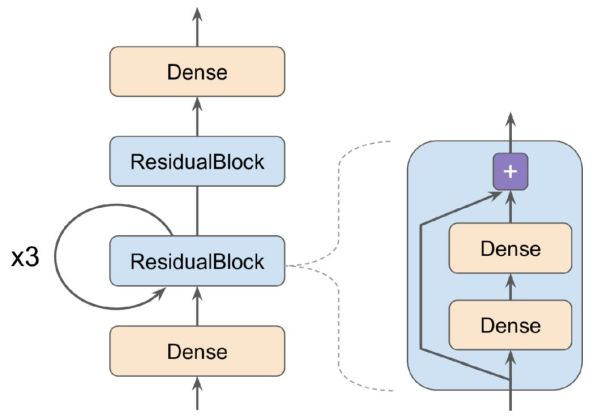

In [136]:
# E.g., a resedual block:

from IPython import display
display.Image("./images/ResidualBlock-.jpg", width=400, height=277)

In [134]:
X_new_scaled = X_test_scaled

In [135]:
class ResidualBlock(keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(n_neurons, activation="elu",
                                          kernel_initializer="he_normal")
                       for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z

In [137]:
class ResidualRegressor(keras.models.Model):    
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(30, activation="elu",
                                          kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [138]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [139]:
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 108us/sample - loss: 11.4379
Epoch 2/5
11610/11610 [==============================] - 1s 44us/sample - loss: 1.7623
Epoch 3/5
11610/11610 [==============================] - 1s 44us/sample - loss: 1.4744
Epoch 4/5
11610/11610 [==============================] - 1s 44us/sample - loss: 0.6444
Epoch 5/5
5160/5160 [==============================] - 0s 36us/sample - loss: 0.6048


In [140]:
model.save("my_custom_model.ckpt")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_custom_model.ckpt\assets


In [141]:
model = keras.models.load_model("my_custom_model.ckpt")

In [142]:
history = model.fit(X_train_scaled, y_train, epochs=5)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 125us/sample - loss: 0.6816
Epoch 2/5
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5100
Epoch 3/5
11610/11610 [==============================] - 1s 45us/sample - loss: 0.6881
Epoch 4/5
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5656
Epoch 5/5
11610/11610 [==============================] - 1s 46us/sample - loss: 0.7512


In [143]:
# keras.models.Model is a subclass of keras.layers.Layer, but layers are suggested to be defined by the latter.
# Here, the layer object could be implemented into the model using the Sequential API.

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

block1 = ResidualBlock(2, 30)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal"),
    block1, block1, block1, block1,
    ResidualBlock(2, 30),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=5)
score = model.evaluate(X_test_scaled, y_test)
y_pred = model.predict(X_new_scaled)

Train on 11610 samples
Epoch 1/5
11610/11610 [==============================] - 1s 93us/sample - loss: 0.9281
Epoch 2/5
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4480
Epoch 3/5
11610/11610 [==============================] - 0s 40us/sample - loss: 0.7364
Epoch 4/5
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4003
Epoch 5/5
5160/5160 [==============================] - 0s 32us/sample - loss: 0.4289


- Beyond defining losses and metrics based on labels, predictions, and sample weights, they can also be defined by model internals using the `add_metric()` and `add_loss()` methods of a custom model.
- E.g., a reconstruction loss (using the auxiliary output of a hidden layer) is added to the regular loss as a form of (sometimes useful) regularization (since it preserves some information).

In [144]:
class ReconstructingRegressor(keras.models.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [keras.layers.Dense(30, activation="selu",
                                          kernel_initializer="lecun_normal")
                       for _ in range(5)]
        self.out = keras.layers.Dense(output_dim)
        self.reconstruct = keras.layers.Dense(8) # workaround for TF issue mentioned below
        self.reconstruction_mean = keras.metrics.Mean(name="reconstruction_error")

    #Commented out due to TF issue #46858
    #def build(self, batch_input_shape): # the extra layer with unknown number of input can be implemented by build().
    #    n_inputs = batch_input_shape[-1]
    #    self.reconstruct = keras.layers.Dense(n_inputs)
    #    super().build(batch_input_shape)

    def call(self, inputs, training=None): # it processes the inputs, and passes the outputs
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss) # 0.05 is just a hyperparameter
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z) # it also print losses and metrics over the epoch

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="nadam")
history = model.fit(X_train_scaled, y_train, epochs=2)
y_pred = model.predict(X_test_scaled)

### Custom Training Loops

- They can be written after defining a model (without compiling),
- we rarely need them (e.g, the *Wide & Deep* paper as requires two optimizers),
- they are very error-prone, and
- most importantly, such training loops do not tackle layers with different behaviors in training and testing.

In [184]:
# e.g. a simple model is defined

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

l2_reg = keras.regularizers.l2(0.05)
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=l2_reg),
    keras.layers.Dense(1, kernel_regularizer=l2_reg)
])

In [185]:
def random_batch(X, y, batch_size=32): # Data API may have better alternatives.
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [187]:
def print_status_bar(iteration, total, loss, metrics=None):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{}/{} - ".format(iteration, total) + metrics, end=end) # ensuring the status bar is in the same line.

In [188]:
# showing the status bar

import time

mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 - loss: 0.0900 - mean_square: 858.5000


In [189]:
# A fancier version with a progress bar:

def progress_bar(iteration, total, size=30):
    running = iteration < total
    c = ">" if running else "="
    p = (size - 1) * iteration // total
    fmt = "{{:-{}d}}/{{}} [{{}}]".format(len(str(total)))
    params = [iteration, total, "=" * p + c + "." * (size - p - 1)]
    return fmt.format(*params)

In [192]:
progress_bar(3500, 10000, size=6)

' 3500/10000 [=>....]'

In [193]:
def print_status_bar(iteration, total, loss, metrics=None, size=30):
    metrics = " - ".join(["{}: {:.4f}".format(m.name, m.result())
                         for m in [loss] + (metrics or [])])
    end = "" if iteration < total else "\n"
    print("\r{} - {}".format(progress_bar(iteration, total), metrics), end=end)

In [194]:
mean_loss = keras.metrics.Mean(name="loss")
mean_square = keras.metrics.Mean(name="mean_square")
for i in range(1, 50 + 1):
    loss = 1 / i
    mean_loss(loss)
    mean_square(i ** 2)
    print_status_bar(i, 50, mean_loss, [mean_square])
    time.sleep(0.05)

50/50 [==============================] - loss: 0.0900 - mean_square: 858.5000


In [197]:
# first define the hyperparameters, optimizer, loss, and metric functions.

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error
mean_loss = keras.metrics.Mean()
metrics = [keras.metrics.MeanAbsoluteError()]

In [198]:
# then create the custom loop

for epoch in range(1, n_epochs + 1):
    print("Epoch {}/{}".format(epoch, n_epochs))
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(X_train_scaled, y_train)
        
        # make a prediction on one batch using the model as the function
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            # model.losses are relevant to the hidden layer regulizers
            
            # add_n() sums multiple tensors of the same shape and data type
            loss = tf.add_n([main_loss] + model.losses)
        
        gradients = tape.gradient(loss, model.trainable_variables)
        
        # the optimizer’s clipnorm or clipvalue hyperparameter are taken into account authomatically
        # any other transformation to the gradients should be added before apply_gradients()
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # update the training loop if you used kernel_constraint or bias_constraint
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))
        
        # update the mean loss and the metrics
        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)
        
        print_status_bar(step * batch_size, len(y_train), mean_loss, metrics)
    print_status_bar(len(y_train), len(y_train), mean_loss, metrics)
    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11610/11610 [==============================] - mean: 1.3955 - mean_absolute_error: 0.5722
Epoch 2/5
11610/11610 [==============================] - mean: 0.6774 - mean_absolute_error: 0.5280
Epoch 3/5
11610/11610 [==============================] - mean: 0.6351 - mean_absolute_error: 0.5177
Epoch 4/5
11610/11610 [==============================] - mean: 0.6384 - mean_absolute_error: 0.5181
Epoch 5/5
11610/11610 [==============================] - mean: 0.6440 - mean_absolute_error: 0.5222


In [204]:
# alternatively

try:
    from tqdm.notebook import trange
    from collections import OrderedDict
    with trange(1, n_epochs + 1, desc="All epochs") as epochs:
        for epoch in epochs:
            with trange(1, n_steps + 1, desc="Epoch {}/{}".format(epoch, n_epochs)) as steps:
                for step in steps: # loops for sampled batches.
                    X_batch, y_batch = random_batch(X_train_scaled, y_train)
                    with tf.GradientTape() as tape:
                        y_pred = model(X_batch)
                        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                        loss = tf.add_n([main_loss] + model.losses)
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    for variable in model.variables:
                        if variable.constraint is not None:
                            variable.assign(variable.constraint(variable))
                    status = OrderedDict()
                    mean_loss(loss)
                    status["loss"] = mean_loss.result().numpy()
                    for metric in metrics:
                        metric(y_batch, y_pred)
                        status[metric.name] = metric.result().numpy()
                    steps.set_postfix(status)
            for metric in [mean_loss] + metrics:
                metric.reset_states()
except ImportError as ex:
    print("To run this cell, please install tqdm, ipywidgets and restart Jupyter")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




### Custom Optimizers

- By `keras.optimizers.Optimizer` subclassing, optimizers can be customized (although rarely).

In [200]:
class MyMomentumOptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }

In [201]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(X_train_scaled, y_train, epochs=5)